## Programming Lab #2
## Foundations of Machine Learning

The purpose of this project is to build predictive algorithms that predict the likelihood a person has a stroke. The data include:
  
  - `age`: Patient age, numeric
  - `avg_glucose_level`: Blood sugar levels, numeric
  - `bmi`: Body mass index, numeric
  - `ever_married`: Ever married, dummy/character (Yes, No)
  - `gender`: Male, Female, or Other, character
  - `heart_disease`: Has heart disease, dummy
  - `hypertension`: Has hypertension, dummy
  - `id`: Study identification number
  - `Residence_type`: Type of residence, dummy/character (Urban, Rural)
  - `smoking_status`: Former, never, or current smoker, categorical
  - `work_type`: Employment type (Never worked (Never_worked), homemaker ("children"), Public sector employment (Govt_job), Private sector employment (`Private`), Self-employed (`Self-employed`)
  - `stroke`: Suffered a stroke in the sample period
  
The data come in two files: `training_data.csv`, which you should use to build your models, and `testing_data.csv`, which you should use to test your models. The models must be trained on the training data and tested on the testing data, but providing both files allows you to experiment with your choices and iterate on model designs. If performance drops on the testing data, you know there's a problem.
  
You can use any of the tools presented in class: $k$ nearest neighbor, linear models, or decision trees. In principle, $k$ means clustering might also be helpful for looking for patterns in the data that the other methods might miss. Using canned versions of more advanced tools (boosting, bagging, random forests, neural networks, etc.) is deeply unsporting and thus not allowed. You can be creative about transforming variables, or combining decision trees with linear models or $k$NN. Try something interesting. Fail extravagantly. The goal is to work on an intellectually interesting question that is similar to the tasks that data scientists are called on to do every day.
  
We will compare the groups' models to see if there are common trends or significant differences, and also to declare **The Winners** on the basis of whichever team achieves the lowest $RMSE$ on the testing data. A simple linear model with some polynomials and dummy variables achieves an $R^2$ of .087 and a $RMSE$ of .206. 

In [1]:
# Initalizing a print function to limit repetition

def pn(x):
    print(x, '\n')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_train = pd.read_csv('./data/training_data.csv')
df_test = pd.read_csv('./data/testing_data.csv')
pn(df_train.head()) # view the dataframe

gdf_train = pd.DataFrame.copy(df_train) # make df that we can edit
gdf_test = pd.DataFrame.copy(df_test) # make df that we can edit

# Look at some stats
pn(gdf_train.describe())  #see that bmi is the one missing values
pn(gdf_test.describe()) #see that bmi is the one missing values

   Unnamed: 0     id  gender   age  hypertension  heart_disease ever_married  \
0        2465  68685    Male  36.0             0              0          Yes   
1        4311  59058  Female  45.0             0              0          Yes   
2        2375  46068    Male  58.0             0              0           No   
3        5017  36837  Female  61.0             0              0          Yes   
4         753  30550  Female  78.0             0              0           No   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0       Govt_job          Urban              65.87  32.2  formerly smoked   
1       Govt_job          Rural              68.66  25.3     never smoked   
2  Self-employed          Rural             170.93  30.7          Unknown   
3  Self-employed          Urban              69.88  27.1     never smoked   
4        Private          Urban             103.86  30.6          Unknown   

   stroke  
0       0  
1       0  
2       0  
3       

In [3]:
# Impute bmi missing values
gdf_train['bmi'] = gdf_train['bmi'].fillna(gdf_train['bmi'].mean())
gdf_test['bmi'] = gdf_test['bmi'].fillna(gdf_test['bmi'].mean())

# Look at some stats
pn(gdf_train.describe())  # check if bmi was imputed
pn(gdf_test.describe()) # check if bmi was imputed

        Unnamed: 0            id          age  hypertension  heart_disease  \
count  4087.000000   4087.000000  4087.000000   4087.000000    4087.000000   
mean   2561.672865  36383.068265    43.324169      0.097871       0.056031   
std    1474.961020  21189.857848    22.531019      0.297177       0.230010   
min       1.000000     67.000000     0.080000      0.000000       0.000000   
25%    1295.500000  17417.500000    26.000000      0.000000       0.000000   
50%    2556.000000  36814.000000    45.000000      0.000000       0.000000   
75%    3831.500000  54584.500000    61.000000      0.000000       0.000000   
max    5110.000000  72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        4087.000000  4087.000000  4087.000000  
mean          106.010396    28.923371     0.048691  
std            45.047912     7.688969     0.215248  
min            55.120000    10.300000     0.000000  
25%            77.295000    23.9

In [4]:
### Data Cleaning

## cleaning smoking_status var:
#for smoking status two options: remove nulls or make unkowns as a smoker
#removing Unknown values for smoking
var = 'smoking_status'
pn(gdf_train[var].value_counts()) #1241 unknown values for smoking status of train, which is 30% of data 
pn(gdf_test[var].value_counts()) #303 unknown values for smoking status of test
gdf_train[var] = gdf_train[var].replace('Unknown', np.nan)
gdf_test[var] = gdf_test[var].replace('Unknown', np.nan)
gdf_train[var+'_NA'] = gdf_train[var].isnull()
gdf_test[var+'_NA'] = gdf_test[var].isnull()
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # confirms checks for NAs
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # confirms checks for NAs 

never smoked       1505
Unknown            1241
formerly smoked     699
smokes              642
Name: smoking_status, dtype: int64 

never smoked       387
Unknown            303
formerly smoked    186
smokes             147
Name: smoking_status, dtype: int64 

Total Missings: 
 1241 

Total Missings: 
 303 



In [5]:
print(pd.crosstab(gdf_train[var],gdf_train['stroke']),'\n') #cant assume anything with the stroke, but appears that former smokers are more likely to have a stroke by a little
print(pd.crosstab(gdf_test[var],gdf_test['stroke']),'\n') #cant assume anything with the stroke 

#no cross tab helping lead to any answers

stroke              0   1
smoking_status           
formerly smoked   645  54
never smoked     1434  71
smokes            605  37 

stroke             0   1
smoking_status          
formerly smoked  170  16
never smoked     368  19
smokes           142   5 



In [6]:
# Removing missing values
gdf_train= gdf_train.dropna(subset=[var])
pn(gdf_train[var].describe()) # looks like the stats did not change
print('Total Missings After Drop: \n', sum(gdf_train[var].isnull()),'\n') # checks to see if drop was successful
gdf_test= gdf_test.dropna(subset=[var])
pn(gdf_test[var].describe()) # looks like the stats did not change
print('Total Missings After Drop: \n', sum(gdf_test[var].isnull()),'\n') # checks to see if drop was successful

count             2846
unique               3
top       never smoked
freq              1505
Name: smoking_status, dtype: object 

Total Missings After Drop: 
 0 

count              720
unique               3
top       never smoked
freq               387
Name: smoking_status, dtype: object 

Total Missings After Drop: 
 0 



In [7]:
## cleaning id var:

missing_values_train = gdf_train['id'].isnull().sum()
missing_values_test = gdf_test['id'].isnull().sum()

# print the number of missing values
print(f"Number of missing values in training set 'id' column: {missing_values_train}")
print(f"Number of missing values in training set 'id' column: {missing_values_test}")

# Check for duplicated id values
duplicated_ids_train = gdf_train.duplicated('id').sum()
duplicated_ids_test = gdf_test.duplicated('id').sum()

# If there are any duplicated IDs, 'duplicated_ids' will contain those rows
print(f"\nduplicated IDs found in training set: {duplicated_ids_train}" )
print(f"duplicated IDs found in testing set: {duplicated_ids_train}")

# id values seem clean

Number of missing values in training set 'id' column: 0
Number of missing values in training set 'id' column: 0

duplicated IDs found in training set: 0
duplicated IDs found in testing set: 0


In [8]:
## cleaning Residence_type var:

# print unique variables
print("Unique Residence_type values in training set:", gdf_train["Residence_type"].unique())
print("Unique Residence_type values in testing set:", gdf_test["Residence_type"].unique())

# Check for nans
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # confirms checks for NAs
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # confirms checks for NAs 

# Residence_type var already seems clean

Unique Residence_type values in training set: ['Urban' 'Rural']
Unique Residence_type values in testing set: ['Urban' 'Rural']
Total Missings: 
 0 

Total Missings: 
 0 



In [9]:
print(pd.crosstab(gdf_train["Residence_type"],gdf_train['stroke']),'\n') # Urban areas may have slightly higher stroke rates
print(pd.crosstab(gdf_test["Residence_type"],gdf_test['stroke']),'\n') 

stroke             0   1
Residence_type          
Rural           1331  80
Urban           1353  82 

stroke            0   1
Residence_type         
Rural           325  16
Urban           355  24 



In [10]:
## cleaning work_type var:

var = 'work_type'
print(gdf_train[var].value_counts()) #no unknowns, they add up to 4087
print(gdf_test[var].value_counts()) #no unknowns, adds up to 1023
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # confirms checks for NAs
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # confirms checks for NAs 
# no need to clean anything

Private          1811
Self-employed     538
Govt_job          434
children           55
Never_worked        8
Name: work_type, dtype: int64
Private          474
Self-employed    125
Govt_job         101
children          14
Never_worked       6
Name: work_type, dtype: int64
Total Missings: 
 0 

Total Missings: 
 0 



In [11]:
print(pd.crosstab(gdf_train[var],gdf_train['stroke']),'\n') # Self-employed may have slightly higher stroke rates
print(pd.crosstab(gdf_test[var],gdf_test['stroke']),'\n') 

stroke            0   1
work_type              
Govt_job        414  20
Never_worked      8   0
Private        1714  97
Self-employed   493  45
children         55   0 

stroke           0   1
work_type             
Govt_job        96   5
Never_worked     6   0
Private        451  23
Self-employed  113  12
children        14   0 



count    2846.000000
mean       48.984891
std        18.824734
min        10.000000
25%        34.000000
50%        50.000000
75%        63.000000
max        82.000000
Name: age, dtype: float64 

count    720.000000
mean      48.336111
std       19.073705
min       10.000000
25%       32.000000
50%       50.000000
75%       63.000000
max       82.000000
Name: age, dtype: float64 

Total Missings: 
 0 

Total Missings: 
 0 



<Axes: >

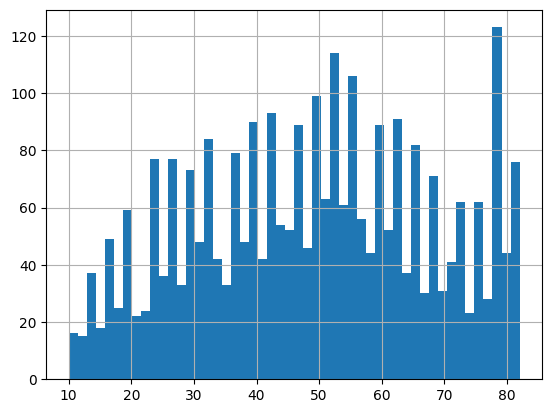

In [12]:
## cleaning age var:
var = 'age'

# Exploring missing values
pn(gdf_train[var].describe()) # looks good, numeric, ages range from 0 to 82
pn(gdf_test[var].describe()) # looks good, numeric, ages range from 0 to 82
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # confirms checks for NAs
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # confirms checks for NAs 
# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at age distribution in sample
gdf_train[var].hist(bins=50)

count    2846.000000
mean      108.810306
std        48.059458
min        55.120000
25%        77.465000
50%        92.860000
75%       116.440000
max       271.740000
Name: avg_glucose_level, dtype: float64 

count    720.000000
mean     109.660722
std       49.229437
min       55.250000
25%       77.407500
50%       91.875000
75%      118.520000
max      263.560000
Name: avg_glucose_level, dtype: float64 

Total Missings: 
 0 

Total Missings: 
 0 



<Axes: >

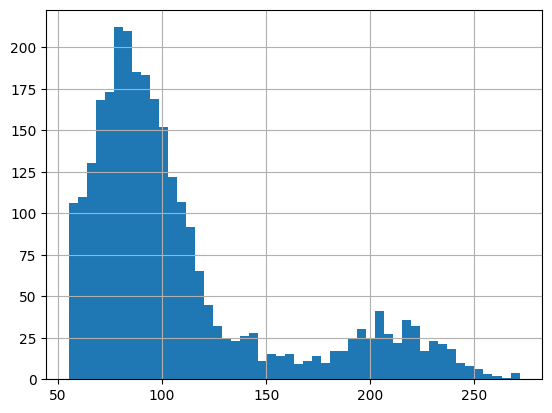

In [13]:
## cleaning avg_glucose_level var:
var = 'avg_glucose_level'

# Exploring missing values
pn(gdf_train[var].describe()) # count looks right
pn(gdf_test[var].describe()) # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # confirms checks for NAs
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # confirms checks for NAs 
# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at average glucose level distribution in sample
gdf_train[var].hist(bins=50) # interesting how there seems to be two probability peaks

count    2846.000000
mean       30.263296
std         7.116958
min        14.100000
25%        25.500000
50%        28.923371
75%        33.700000
max        92.000000
Name: bmi, dtype: float64 

Total Missings: 
 0 

count    720.000000
mean      30.124388
std        7.314254
min       11.500000
25%       25.075000
50%       28.772579
75%       34.100000
max       64.800000
Name: bmi, dtype: float64 

Total Missings: 
 0 

Axes(0.125,0.11;0.775x0.77)


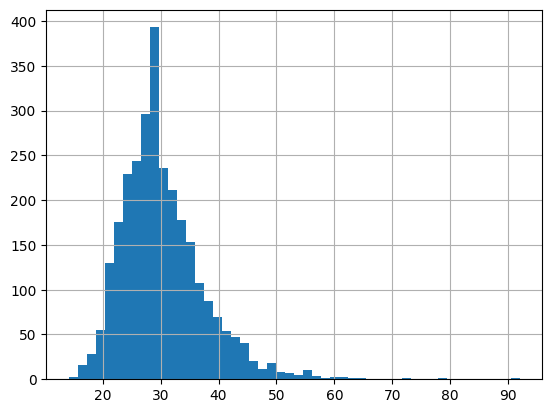

In [14]:
## cleaning bmi var:
var = 'bmi'

# Exploring mising values
pn(gdf_train[var].describe()) # some are missing
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # checks for number of NAs, about 3.9% of sample
pn(gdf_test[var].describe()) # some are missing
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # checks for number of NAs, about 3.8% of sample
# Because the missing values make up less than 5% of the samples, the nans will be removed

# Take a look at bmi distribution in sample
print(gdf_train[var].hist(bins=50))

count    2846.000000
mean       30.263296
std         7.116958
min        14.100000
25%        25.500000
50%        28.923371
75%        33.700000
max        92.000000
Name: bmi, dtype: float64 

Total Missings After Drop: 
 0 

count    720.000000
mean      30.124388
std        7.314254
min       11.500000
25%       25.075000
50%       28.772579
75%       34.100000
max       64.800000
Name: bmi, dtype: float64 

Total Missings After Drop: 
 0 

Axes(0.125,0.11;0.775x0.77)


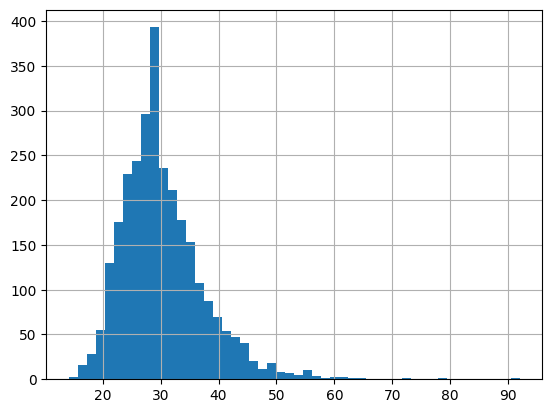

In [15]:
# Removing missing values
gdf_train= gdf_train.dropna(subset=[var])
pn(gdf_train[var].describe()) # looks like the stats did not change
print('Total Missings After Drop: \n', sum(gdf_train[var].isnull()),'\n') # checks to see if drop was successful
gdf_test= gdf_test.dropna(subset=[var])
pn(gdf_test[var].describe()) # looks like the stats did not change
print('Total Missings After Drop: \n', sum(gdf_test[var].isnull()),'\n') # checks to see if drop was successful

# Take a look at bmi distribution in sample
print(gdf_train[var].hist(bins=50)) # doesn't look like distribution was effected by droped observations

Training Set:
count    2846.000000
mean        0.065706
std         0.247811
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: heart_disease, dtype: float64
Total Missings: 
 0 

Test Set:
count    720.000000
mean       0.056944
std        0.231898
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: heart_disease, dtype: float64
Total Missings: 
 0 



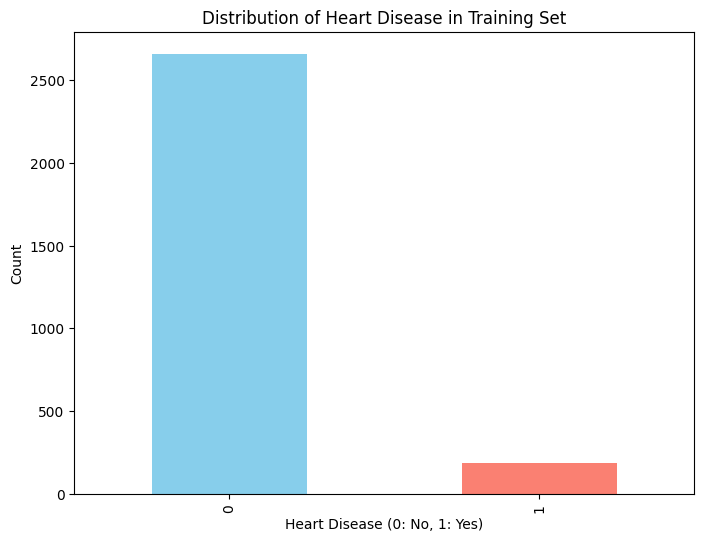

In [16]:
## cleaning heart_disease var:

var = 'heart_disease'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Heart Disease in Training Set')
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

In [17]:
print(pd.crosstab(gdf_train[var],gdf_train['stroke']),'\n') # Heart disease seems to have a strong correlation with stroke compared to other variables, will be a good indicator
print(pd.crosstab(gdf_test[var],gdf_test['stroke']),'\n') 

stroke            0    1
heart_disease           
0              2529  130
1               155   32 

stroke           0   1
heart_disease         
0              646  33
1               34   7 



Training Set:
count    2846.000000
mean        0.125439
std         0.331274
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: hypertension, dtype: float64
Total Missings: 
 0 

Test Set:
count    720.000000
mean       0.123611
std        0.329366
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: hypertension, dtype: float64
Total Missings: 
 0 



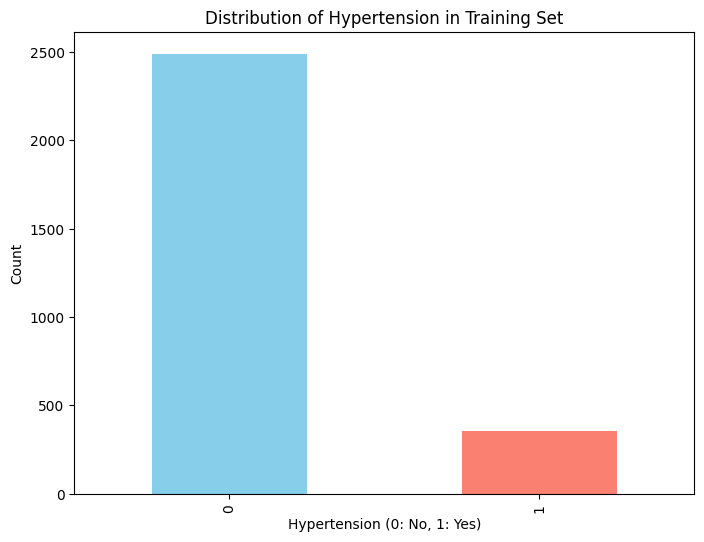

In [18]:
## cleaning hypertension var:

var = 'hypertension'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Hypertension in Training Set')
plt.xlabel('Hypertension (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

In [19]:
print(pd.crosstab(gdf_train[var],gdf_train['stroke']),'\n') # Hypertension seems to have a strong correlation with stroke compared to other variables, will be a good indicator
print(pd.crosstab(gdf_test[var],gdf_test['stroke']),'\n') 

stroke           0    1
hypertension           
0             2378  111
1              306   51 

stroke          0   1
hypertension         
0             602  29
1              78  11 



Training Set:
count       2846
unique         3
top       Female
freq        1726
Name: gender, dtype: object
Female    1726
Male      1119
Other        1
Name: gender, dtype: int64
Female    1726
Male      1119
Name: gender, dtype: int64
Total Missings: 
 0 

Test Set:
count        720
unique         2
top       Female
freq         432
Name: gender, dtype: object
Female    432
Male      288
Name: gender, dtype: int64
Total Missings: 
 0 



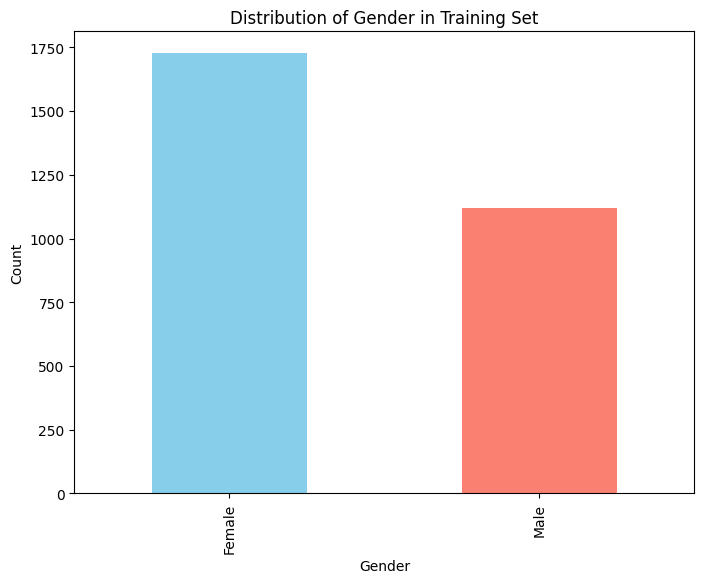

In [20]:
## cleaning gender var:

var = 'gender'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print(gdf_train[var].value_counts()) #need to remove other
gdf_train = gdf_train[gdf_train[var] != 'Other']
print(gdf_train[var].value_counts())

print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right, notice, there are onlu two unique values, so will have to manually enter Other in one hot encoding
print(gdf_test[var].value_counts())  # count looks right
gdf_test = gdf_test[gdf_test[var] != 'Other']

print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Gender in Training Set')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [21]:
print(pd.crosstab(gdf_train[var],gdf_train['stroke']),'\n') # Can't conclude anything
print(pd.crosstab(gdf_test[var],gdf_test['stroke']),'\n') 

stroke     0   1
gender          
Female  1634  92
Male    1049  70 

stroke    0   1
gender         
Female  408  24
Male    272  16 



Training Set:
count     2845
unique       2
top        Yes
freq      2169
Name: ever_married, dtype: object
Total Missings: 
 0 

Test Set:
count     720
unique      2
top       Yes
freq      541
Name: ever_married, dtype: object
Total Missings: 
 0 



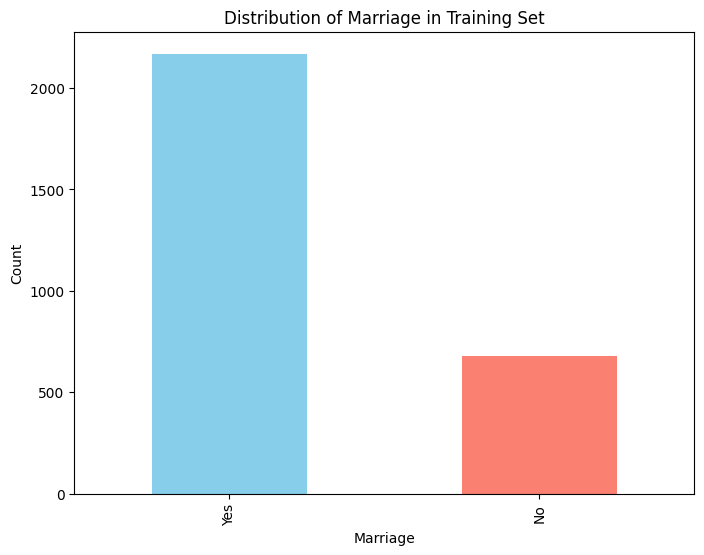

In [22]:
## cleaning ever_married var:

var = 'ever_married'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Marriage in Training Set')
plt.xlabel('Marriage')
plt.ylabel('Count')
plt.show()

In [23]:
print(pd.crosstab(gdf_train[var],gdf_train['stroke']),'\n') # Marriage does seem to affect stroke rates
print(pd.crosstab(gdf_test[var],gdf_test['stroke']),'\n') 

stroke           0    1
ever_married           
No             656   20
Yes           2027  142 

stroke          0   1
ever_married         
No            178   1
Yes           502  39 



In [24]:
## cleaning stroke var:

var = 'stroke'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right, notice
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

Training Set:
count    2845.000000
mean        0.056942
std         0.231773
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64
Total Missings: 
 0 

Test Set:
count    720.000000
mean       0.055556
std        0.229221
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: stroke, dtype: float64
Total Missings: 
 0 



**Cleaned dataframes**

In [25]:
gdf_train.head()
gdf_train.describe()

,Unnamed: 0,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,2535.589807,36587.777153,48.992970,0.125483,0.065729,108.798172,30.266060,0.056942
std,1494.291095,21287.253142,18.823107,0.331324,0.247852,48.063546,7.116681,0.231773
min,1.000000,67.000000,10.000000,0.000000,0.000000,55.120000,14.100000,0.000000
25%,1238.000000,17466.000000,34.000000,0.000000,0.000000,77.460000,25.500000,0.000000
50%,2521.000000,37150.000000,50.000000,0.000000,0.000000,92.860000,28.923371,0.000000
75%,3831.000000,54918.000000,63.000000,0.000000,0.000000,116.440000,33.700000,0.000000
max,5108.000000,72915.000000,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [26]:
gdf_test.head()
gdf_test.describe()

,Unnamed: 0,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,2481.895833,37541.118056,48.336111,0.123611,0.056944,109.660722,30.124388,0.055556
std,1476.372155,21052.205817,19.073705,0.329366,0.231898,49.229437,7.314254,0.229221
min,2.000000,239.000000,10.000000,0.000000,0.000000,55.250000,11.500000,0.000000
25%,1152.750000,20179.250000,32.000000,0.000000,0.000000,77.407500,25.075000,0.000000
50%,2508.500000,38098.500000,50.000000,0.000000,0.000000,91.875000,28.772579,0.000000
75%,3750.750000,55223.750000,63.000000,0.000000,0.000000,118.520000,34.100000,0.000000
max,5109.000000,72861.000000,82.000000,1.000000,1.000000,263.560000,64.800000,1.000000


Creating numerical dataframes using one hot encoding so a decision tree can be used

In [27]:
## Getting dataframes ready for training and testing
from sklearn.preprocessing import PolynomialFeatures

# Train numeric variables
X_train_numeric = gdf_train.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]

# Exapanding numeric variables
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

# Train categorical variables
dummies = pd.concat([ pd.get_dummies(gdf_train['work_type'],dtype='int'), # work_type has more than two options
                      pd.get_dummies(gdf_train['Residence_type'],dtype='int',drop_first=True), # residence_type only has "Urban" or "Rural"
                      pd.get_dummies(gdf_train['smoking_status'],dtype='int'), # smoking_status has more than two options
                      pd.get_dummies(gdf_train['ever_married'],dtype='int',drop_first=True) # ever_married only has "Yes" or "No"
                    ],axis=1)
dummies = dummies.reset_index()

# Concatinating numeric and one-hot-encoded categorical variables
X_train = pd.concat([continuous,dummies],axis=1)

# Set up outcome
y_train = gdf_train['stroke']

In [28]:
# Test numeric variables
X_test_numeric = gdf_test.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]

# Exapanding numeric variables
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

# Test categorical variables
dummies = pd.concat([ pd.get_dummies(gdf_test['work_type'],dtype='int'),
                      pd.get_dummies(gdf_test['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(gdf_test['smoking_status'],dtype='int'),
                      pd.get_dummies(gdf_test['ever_married'],dtype='int',drop_first=True)],axis=1)
dummies = dummies.reset_index()

# Concatinating numeric and one-hot-encoded categorical variables
X_test = pd.concat([continuous,dummies],axis=1)

# Set up outcome
y_test = gdf_test['stroke']

In [29]:
## Linear Model
from sklearn.linear_model import LinearRegression # Import linear regression model

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
R2_lm = reg.score(X_test, y_test)
print('R2: ', R2_lm) # R squared measure
y_hat = reg.predict(X_test)
N = len(y_test)
RMSE_lm = (np.sum( (y_test - y_hat)**2)/N )**.5
print('RMSE: ', RMSE_lm )   # R squared measure

R2:  -0.09318053598475151
RMSE:  0.23949579954395847


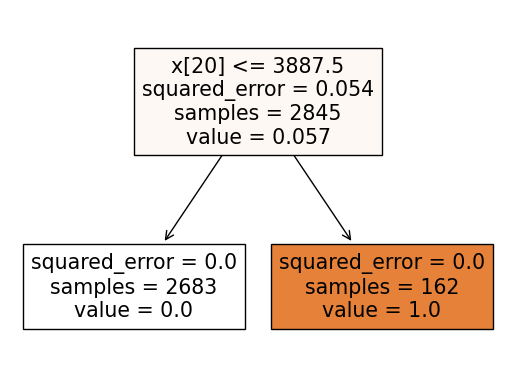

Coefficient of determination:  -0.0587847402041457
RMSE:  0.23570226039551584


In [30]:
## Decision Tree Model
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

tree_model = tree.DecisionTreeRegressor(max_depth=10) # Set up the tree
cart = tree_model.fit(X_train, y_train) # Fit the tree
tree.plot_tree(cart,filled=True) # Visualize the tree
plt.show()


# Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test) # Run test data through model to get y predictions
N_test = len(y_test) # number of outputs
residuals_cart = y_test - y_hat_cart # difference between predicted and real values

# Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 ) # Sum of squared errors
MSE_cart = SSE_cart/N_test # Mean of sum of squarerd errors
RMSE_cart = (MSE_cart)**(1/2) # Root of mean of sum of squared errors
TSS = np.sum( (y_test - y_train.mean())**2 )
R2_cart = 1 - SSE_cart/TSS # Coefficient of determination
print('Coefficient of determination: ', R2_cart) # R squared measure
print('RMSE: ', RMSE_cart)

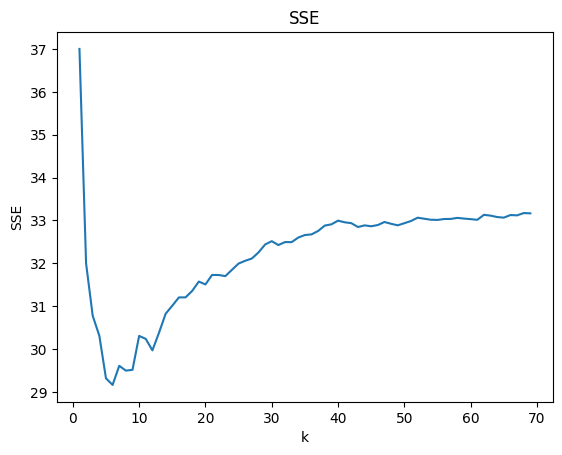

In [31]:
## KNeighborsRegressor Model
from sklearn.neighbors import KNeighborsRegressor

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)

# Determine optimal k:
k_bar = 70
k_grid = np.arange(1,k_bar) # The range of k's to consider
SSE = np.zeros(k_bar-1) # For comparison purposes, store the training error
for k in range(k_bar-1):
    model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
    SSE[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
SSE_min = np.min(SSE) # Lowest recorded SSE
min_index = np.where(SSE==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index][0] # Find the optimal value of k

# SSE plot:
plt.plot(k_grid,SSE)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title('SSE')
plt.show()

In [32]:
# Fit optimal model:
knn_model = KNeighborsRegressor(n_neighbors=max(3,k_star))
knn_star = knn_model.fit(X_train_knn,y_train)
y_hat_knn = knn_star.predict(X_test_knn)
residuals_knn = y_test - y_hat_knn

In [33]:
# Calculate RMSE and R^2
SSE_knn = np.sum( (y_test-y_hat_knn)**2 )
MSE_knn = SSE_knn/N_test
RMSE_knn = (SSE_knn/N_test)**(1/2)
R2_knn = 1 - SSE_knn/TSS
print(f'RMSE: {RMSE_knn:.2f}')
print(f'R^2: {R2_knn:.2f}')

RMSE: 0.20
R^2: 0.23


In [35]:
## Comparison Table:
gdf = pd.DataFrame({'RMSE':[RMSE_lm,RMSE_cart,RMSE_knn],
                    'R2':[R2_lm,R2_cart,R2_knn]})
gdf.index = ['LM','TREE','KNN']
gdf.head()

,RMSE,R2
LM,0.239496,-0.093181
TREE,0.235702,-0.058785
KNN,0.201269,0.227969


kNN was clearly better than the others, so we used it as a base to build a model that integrates a few types of models.

In [37]:
##  Decision Tree Regressor with a KNN neighbors model

# from sklearn.ensemble import VotingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

# # Initialize the Decision Tree Regressor and KNN Regressor models
# dt_model = DecisionTreeRegressor(max_depth=5)
# knn_model = KNeighborsRegressor(n_neighbors=10)  # You can adjust the number of neighbors (k)

# # Initialize the Voting Regressor with both models
# voting_model = VotingRegressor(estimators=[('decision_tree', dt_model), ('knn', knn_model)])

# # Train the ensemble model
# voting_model.fit(X_train, y_train.values.ravel())  # Note: ravel() is used to convert y_train to a 1D array

# # Make predictions on the test set
# y_pred_voting = voting_model.predict(X_test)

# # Calculate RMSE for the ensemble model
# rmse_voting = mean_squared_error(y_test, y_pred_voting, squared=False)
# print(f'RMSE: {rmse_voting:.2f}')

# # Calculate R-squared for the ensemble model
# r2_voting = r2_score(y_test, y_pred_voting)
# print(f'R^2: {r2_voting:.2f}')

RMSE: 0.23
R^2: -0.05


# BELOW THIS IS WHAT WAS ORIGINALLY IN THE FILE

In [349]:
y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())

In [78]:
## Linear Model
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#
dummies = pd.concat([ pd.get_dummies(X_train['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_train = pd.concat([continuous,dummies],axis=1)

X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

dummies = pd.concat([ pd.get_dummies(X_test['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_test = pd.concat([continuous,dummies],axis=1)

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
print('R2: ', reg.score(Z_test, y_test)) # R squared measure
y_hat = reg.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )   # R squared measure


AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names_out'

This is supposed to be fairly "fun," so please do not turn it into a combinatorial nightmare of comparing thousands of model specifications. Settle on a strategy you think is promising, crank it out, and write up the results. Your time and energy are valuable, so learn to recognize when the marginal cost of another twenty minutes on a project exceeds the benefit in terms of improving the results and your grade.
  
## Paper format

The format of the paper should be:

  - Summary: A one paragraph description of the question, methods, and results (about 350 words).
  - Data: One to two pages discussing the data and key variables, and any challenges in reading, cleaning, and preparing them for analysis.
  - Results: Two to five pages providing visualizations, statistics, a discussion of your methodology, and a presentation of your main findings. 
  - Conclusion: One to two pages summarizing the project, defending it from criticism, and suggesting additional work that was outside the scope of the project.
  - Appendix: If you have a significant number of additional plots or table that you feel are essential to the project, you can put any amount of extra content at the end and reference it from the body of the paper. 

## Submission

Half of each student's grade is based on their commits to the repo. Each student is expected to do something specific that contributes to the overall project outcome. Since commits are recorded explicitly by Git/GitHub, this is observable. A student can contribute by cleaning data, creating visualizations,performing analytic analyses,  or writing about results, but everyone has to do something substantial. A student's work doesn't need to make it into the final report to be valuable and substantial, and fulfill the requirement to make a contribution to the project. 

The other half of each student's grade is based on the written report. Groups will work together on combining results and writing up findings in a Jupyter noteb,ok, using code chunks to execute Python commands and markdown chunks to structure the paper and provide exposition. The notebook should run on Colab or Rivana from beginning to end without any errors.

mbers submit.

## Criteria

The project is graded based on four criteria:

  - Project Concept: What is the strategy for building and testing the group's models? How did the group decide how to use the tools presented so far in class? How did the group compare the performance of the options considered, and settle on a final choice for submission?
  - Wrangling, EDA, and Visualization: How are are missing values handled? For variables with large numbers of missing values, to what extent do the data and documentation provide an explanation for the missing data? If multiple data sources are used, how are the data merged? For the main variables in the analysis, are the relevant data summarized and visualized through a histogram or kernel density plot where appropriate? Are basic quantitative features of the data addressed and explained? How are outliers characterized and addressed? 
  - Analysis: What are the groups' main findings? Do the tables, plots, and statistics support the conclusions? Is the research strategy carried out correctly? If the research strategy succeeds, are the results interpreted correctly and appropriately? If the research strategy fails, is a useful discussion of the flaws of the data collection process or the research strategy discussed?
  - Replication/Documentation: Is the code appropriately commented? Can the main results be replicated from the code and original data files? Are significant choices noted and explained?

Each of the four criteria are equally weighted (25 points out of 100).